## Load parquet

In [1]:
import logging
import pandas as pd

import matplotlib.pyplot as plt
import pandas_ta as ta

In [2]:
df = pd.read_parquet("3_years_500_stocks.parquet")

In [3]:
df.head()

,instrument_id,ts,open_price,close_price,high_price,low_price,volume
0,1,2018-01-23 21:45:00+00:00,114.02,114.02,114.02,114.02,6.0
1,1,2018-01-23 21:35:00+00:00,114.02,114.02,114.02,114.02,10.0
2,1,2018-01-23 20:55:00+00:00,114.20,114.23,114.26,114.16,76837.0
3,1,2018-01-23 20:50:00+00:00,114.37,114.21,114.39,114.19,34299.0
4,1,2018-01-23 20:45:00+00:00,114.33,114.36,114.41,114.31,27240.0


In [4]:
df.groupby("instrument_id").count()

,ts,open_price,close_price,high_price,low_price,volume
instrument_id,,,,,,
1,85215,85215,85215,85215,85215,85215
2,72120,72120,72120,72120,72120,72120
3,98530,98530,98530,98530,98530,98530
4,119009,119009,119009,119009,119009,119009
5,100777,100777,100777,100777,100777,100777
...,...,...,...,...,...,...
528,1588,1588,1588,1588,1588,1588
530,62633,62633,62633,62633,62633,62633
531,70902,70902,70902,70902,70902,70902


## Analyze single stock

### Create dataset with sliding averages

In [41]:
sliding_window_df = df[df["instrument_id"] == 318]

In [42]:
sliding_window_df.head()

,instrument_id,ts,open_price,close_price,high_price,low_price,volume
7521,318,2018-01-23 23:10:00+00:00,43.53,43.53,43.53,43.53,200.0
7522,318,2018-01-23 22:50:00+00:00,43.60,43.59,43.60,43.59,125.0
7523,318,2018-01-23 22:45:00+00:00,43.58,43.58,43.58,43.58,680.0
7524,318,2018-01-23 22:30:00+00:00,43.59,43.52,43.59,43.52,1649.0
7525,318,2018-01-23 22:25:00+00:00,43.59,43.58,43.59,43.58,1303.0


In [39]:
def preprocess_data(df):
    # Sort values with ts
    df = df.sort_values("ts")
    # Reset index
    df = df.reset_index(drop=True)

    # Add MACD
    df.ta.macd(fast=12,slow=26,signal=9,append=True)

    # Add Stochastic RSI
    df.ta.stochrsi(append=True)

    # Rename columns
    df = df.rename(columns={
        "MACD_12_26_9": "MACD",
        "MACDs_12_26_9": "MACDs",
        "MACDh_12_26_9": "MACDh",
        "STOCHRSIk_14_14_3_3": "RSI"})

    # Shift MACD signals
    # TEST!!!
    shift_count = 4
    df["MACD"] = df["MACD"].shift(-shift_count)
    df["MACDs"] = df["MACDs"].shift(-shift_count)
    df["MACDh"] = df["MACDh"].shift(-shift_count)

    # Calc RSI signals
    RSI_oversold_threshold = 20
    RSI_overbouht_threshold = 80

    df["RSI_oversold"] = df["RSI"] <= RSI_oversold_threshold
    df["RSI_overbought"] = df["RSI"] >= RSI_overbouht_threshold

    df["MACD_buy"] = (df["MACDh"] > 0) & (df["MACDh"].shift() <= 0)
    df["MACD_sell"] = (df["MACDh"] <= 0) & (df["MACDh"].shift() > 0)

    # Fill na
    df = df.fillna(0)

    return df

In [43]:
sliding_window_df = preprocess_data(sliding_window_df)
sliding_window_df.head()

,instrument_id,ts,open_price,close_price,high_price,low_price,volume,MACD,MACDh,MACDs,RSI,STOCHRSId_14_14_3_3,RSI_oversold,RSI_overbought,MACD_buy,MACD_sell
0,318,2018-01-23 10:50:00+00:00,43.2,43.45,43.45,43.2,36.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
1,318,2018-01-23 10:50:00+00:00,43.2,43.45,43.45,43.2,36.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
2,318,2018-01-23 11:00:00+00:00,43.4,43.40,43.40,43.4,23.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
3,318,2018-01-23 11:00:00+00:00,43.4,43.40,43.40,43.4,23.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
4,318,2018-01-23 11:05:00+00:00,43.4,43.45,43.45,43.4,114.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False


Show MACD RSI

In [9]:
def color_zone(ax, points, alpha, color):
    start_point = 0
    end_point = 0
    for x in points:
        if start_point == 0:
            start_point = x
            end_point = x + 1
        else:
            if end_point == x:
                # Continue
                end_point += 1
            else:
                # Draw and reset
                ax.axvspan(start_point, end_point, alpha=alpha, color=color)
                start_point = 0
                end_point = 0
    
    if start_point != 0:
        # Draw and reset
        ax.axvspan(start_point, end_point, alpha=alpha, color=color)
        start_point = 0
        end_point = 0

In [10]:
def plot_candles(df):
    width=1
    width2=0.2

    pricesup = df[df["close_price"] >= df["open_price"]]
    pricesdown = df[df["close_price"] < df["open_price"]]

    plt.bar(pricesup.index, pricesup["close_price"] - pricesup["open_price"], width, bottom=pricesup["open_price"], color='g')
    plt.bar(pricesup.index, pricesup["high_price"] - pricesup["close_price"], width2, bottom=pricesup["close_price"], color='g')
    plt.bar(pricesup.index, pricesup["low_price"] - pricesup["open_price"], width2, bottom=pricesup["open_price"], color='g')

    plt.bar(pricesdown.index, pricesdown["close_price"] - pricesdown["open_price"], width, bottom=pricesdown["open_price"], color='r')
    plt.bar(pricesdown.index, pricesdown["high_price"] - pricesdown["close_price"], width2, bottom=pricesdown["close_price"], color='r')
    plt.bar(pricesdown.index, pricesdown["low_price"] - pricesdown["open_price"], width2, bottom=pricesdown["open_price"], color='r')
    plt.grid()

### Plot Signals

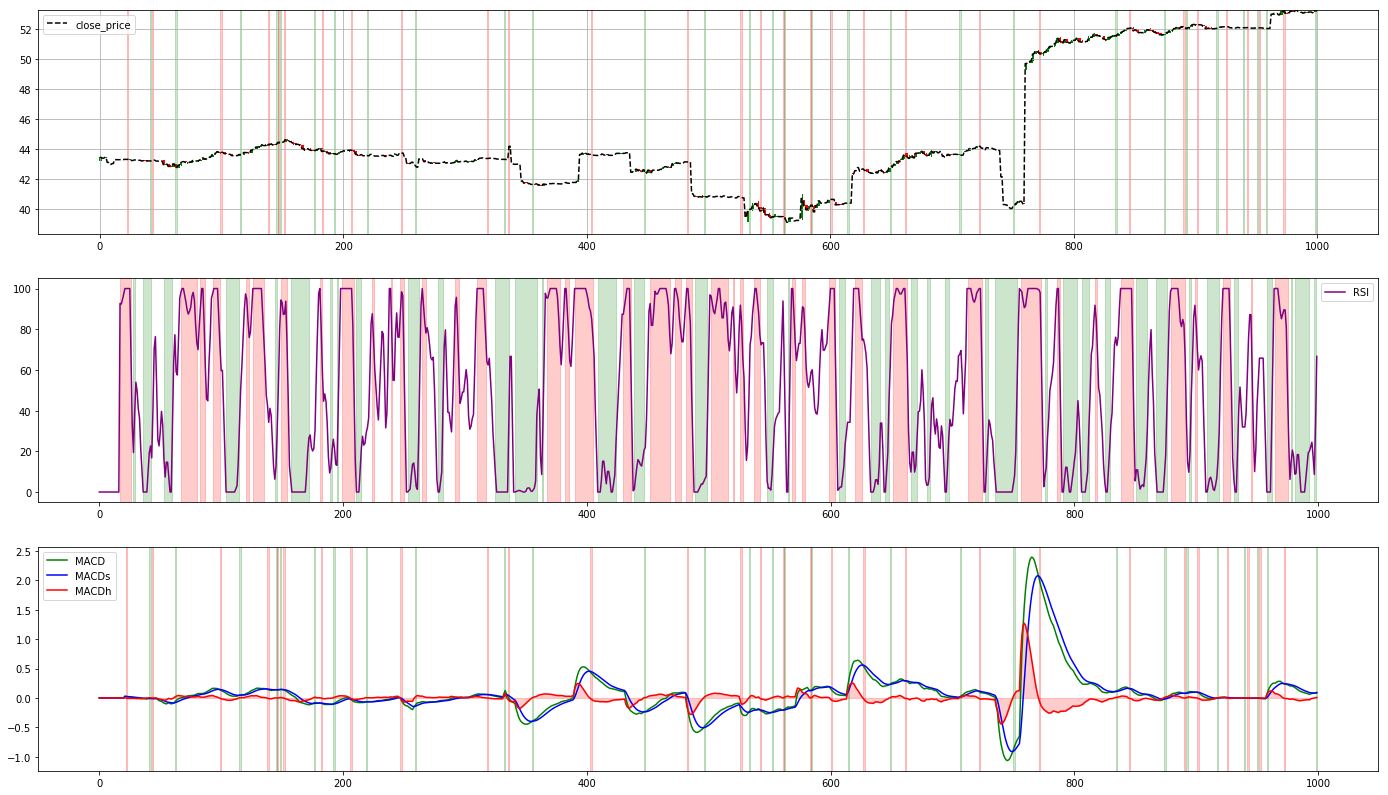

In [47]:
logging.getLogger().setLevel(logging.INFO)

plot_df = sliding_window_df.iloc[:1000]

plt.figure(figsize=(24,14))
plt.subplot(3, 1, 1)
ax = plot_df["close_price"].plot(color="black", linestyle='--')
plot_candles(plot_df)
plt.legend()

plt.subplot(3, 1, 2)
ax1 = plot_df["RSI"].plot(color="purple")
# Show oversold zone
color_zone(ax1, plot_df[plot_df["RSI_oversold"]].index, 0.2, "green")
# Show overbought zone
color_zone(ax1, plot_df[plot_df["RSI_overbought"]].index, 0.2, "red")
plt.legend()

plt.subplot(3, 1, 3)
ax3 = plot_df["MACD"].plot(color="green")
plot_df["MACDs"].plot(ax=ax3,color="blue")
plot_df["MACDh"].plot(ax=ax3,color="red")
ax3.fill_between(plot_df.index, plot_df["MACDh"], alpha=0.2, color="red")
# Show crossover moments
for x in plot_df[plot_df["MACD_buy"]].index:
    ax.axvspan(x, x+1, alpha=0.2, color="green")   
    ax3.axvspan(x, x+1, alpha=0.2, color="green")      
# Show crossunder moments
for x in plot_df[plot_df["MACD_sell"]].index: 
    ax.axvspan(x, x+1, alpha=0.2, color="red")
    ax3.axvspan(x, x+1, alpha=0.2, color="red")
plt.legend()

# Create manual bot

In [45]:
# Create dataset for bot
# Preprocess data
bot_df = preprocess_data(df[df["instrument_id"] == 318].iloc[:1000])
# Select columns
bot_df = bot_df[["ts","open_price","close_price","high_price","low_price","volume","MACDh","MACD","MACDs","RSI"]]
bot_df.head()

,ts,open_price,close_price,high_price,low_price,volume,MACDh,MACD,MACDs,RSI
0,2018-01-23 10:50:00+00:00,43.2,43.45,43.45,43.2,36.0,0.0,0.0,0.0,0.0
1,2018-01-23 10:50:00+00:00,43.2,43.45,43.45,43.2,36.0,0.0,0.0,0.0,0.0
2,2018-01-23 11:00:00+00:00,43.4,43.40,43.40,43.4,23.0,0.0,0.0,0.0,0.0
3,2018-01-23 11:00:00+00:00,43.4,43.40,43.40,43.4,23.0,0.0,0.0,0.0,0.0
4,2018-01-23 11:05:00+00:00,43.4,43.45,43.45,43.4,114.0,0.0,0.0,0.0,0.0


In [46]:
logging.getLogger().setLevel(logging.DEBUG)

from bot import TradingBot

# Test bot
bot = TradingBot(initial_budget=1000,
                rsi_oversold_threshold=20,
                rsi_overbought_threshold=80,
                stop_loss=0.02)
bot.reset()

for index, data in bot_df.iterrows():
    bot.process(data)

bot.profit * 100

DEBUG:root:Step: 41 Buy 23 with price=43.220000
DEBUG:root:Step: 46 Sell 23 with price=43.270000 with profit 0.12% and overall 0.02%
DEBUG:root:Step: 57 Buy 23 with price=42.850000
DEBUG:root:Step: 83 Sell 23 with price=43.290000 with profit 1.03% and overall 0.93%
DEBUG:root:Step: 111 Buy 23 with price=43.560000
DEBUG:root:Step: 119 Sell 23 with price=43.780000 with profit 0.51% and overall 1.33%
DEBUG:root:Step: 143 Buy 22 with price=44.270000
DEBUG:root:Step: 151 Sell 22 with price=44.480000 with profit 0.47% and overall 1.70%
DEBUG:root:Step: 174 Buy 23 with price=43.950000
DEBUG:root:Step: 180 Sell 23 with price=43.980000 with profit 0.07% and overall 1.67%
DEBUG:root:Step: 190 Buy 23 with price=43.690000
DEBUG:root:Step: 205 Sell 23 with price=43.930000 with profit 0.55% and overall 2.12%
DEBUG:root:Step: 215 Buy 23 with price=43.630000
DEBUG:root:Step: 231 Sell 23 with price=43.580000 with profit -0.11% and overall 1.90%
DEBUG:root:Step: 259 Buy 23 with price=42.920000
DEBUG:roo

61.517179500000175

# Test bot on different stocks

In [14]:
def test_bot_profit(df):
    # Preprocess data
    bot_df = preprocess_data(df)
    # Select columns
    bot_df = bot_df[["ts","open_price","close_price","high_price","low_price","volume","MACD","MACDs","RSI"]]

    # Create bot instance
    bot = TradingBot(rsi_oversold_threshold=20,
                    rsi_overbought_threshold=80,
                    stop_loss=0.005)
    # Reset bot
    bot.reset()
    # Run bot
    for index, data in bot_df.iterrows():
        bot.process(data)

    return bot.profit * 100

In [15]:
instruments_df = pd.read_parquet("instruments.parquet")
instruments_df.head()

,name,id,figi
0,JPMorgan,1,BBG000DMBXR2
1,Berkshire Hathaway,2,BBG000DWG505
2,Bank of America Corp,3,BBG000BCTLF6
3,Apple,4,BBG000B9XRY4
4,AT&T,5,BBG000BSJK37


In [16]:
logging.getLogger().setLevel(logging.INFO)

from joblib import Parallel, delayed, parallel_backend

jobs = []

def thread_func(stock_id, stock_df):
    # Check size of dataset
    if stock_df.shape[0] > 8 * 60:
        profit = test_bot_profit(stock_df)

        return {"id":stock_id,"profit":profit}
    
    return {}

with parallel_backend("multiprocessing", n_jobs=12):
    bot_profit_list = Parallel()(delayed(thread_func)(stock_id, stock_df) for stock_id, stock_df in df.groupby("instrument_id"))

bot_profit_df = pd.DataFrame(bot_profit_list).dropna()

bot_profit_df = pd.merge(instruments_df,bot_profit_df,on="id")
 
bot_profit_df

,name,id,figi,profit
0,JPMorgan,1,BBG000DMBXR2,2.896260e+05
1,Berkshire Hathaway,2,BBG000DWG505,2.870326e+04
2,Bank of America Corp,3,BBG000BCTLF6,1.164438e+06
3,Apple,4,BBG000B9XRY4,1.398767e+06
4,AT&T,5,BBG000BSJK37,7.586648e+04
...,...,...,...,...
519,Credit Bank of Moscow,528,BBG00RHTYB60,-9.220445e+00
520,Cabot Oil & Gas,530,BBG000C3GN47,5.677919e+06
521,L Brands,531,BBG000BNGTQ7,2.342774e+09
522,Slack Technologies Inc,532,BBG007G7V505,6.308650e+02


In [17]:
bot_profit_df.sort_values("profit")

,name,id,figi,profit
519,Credit Bank of Moscow,528,BBG00RHTYB60,-9.220445e+00
15,Gazprom,16,BBG00J7PCW56,-1.948000e+00
9,Amazon.com,10,BBG000BVPV84,0.000000e+00
17,Gazpromneft,18,BBG005MCTC09,0.000000e+00
16,Gazprom,17,BBG0000JWX54,0.000000e+00
...,...,...,...,...
356,Invesco,358,BBG000BY2Y78,2.524668e+11
331,Invesco,333,BBG000BY2Y78,2.524668e+11
299,PG&E,301,BBG000BQWPC5,4.070778e+11
316,Micron Technology,318,BBG000C5Z1S3,2.274152e+12


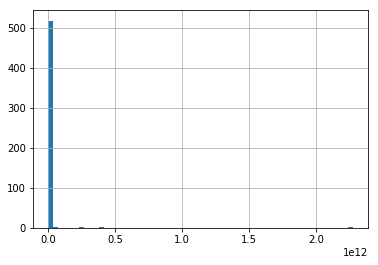

In [18]:
bot_profit_df["profit"].hist(bins=60)

In [19]:
bot_profit_df.describe()

,id,profit
count,524.000000,5.240000e+02
mean,264.240458,1.096103e+10
std,153.072320,1.422422e+11
min,1.000000,-9.220445e+00
25%,132.750000,3.362891e+04
50%,263.500000,2.088048e+05
75%,394.500000,1.749235e+06
max,533.000000,2.274152e+12
